## Assessment: Classifying authors with DistilBERT
Please use the HuggingFace Transformer library for author classification:
* use the DistilBERT architecture this time,
* collect data from 4 authors,
* create, train and evaluate a classifier with DistilBERT and 4 authors.



In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [2]:
%%capture
!pip install tensorflow transformers
!python -m spacy download en

In [3]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import spacy
from urllib.request import urlretrieve
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

## 1. Exercise: Dataset acquisition

In [4]:
nlp = spacy.load("en_core_web_sm")

def sentencesSplit(raw_text):
  doc = nlp(raw_text)
  sentences = [sent.text for sent in doc.sents]
  return sentences

In [5]:
book1="http://www.gutenberg.org/files/2151/2151-0.txt"
book2="https://www.gutenberg.org/cache/epub/70589/pg70589.txt"
book3="https://www.gutenberg.org/cache/epub/42671/pg42671.txt"
book4="https://www.gutenberg.org/cache/epub/67138/pg67138.txt"
urlretrieve(book1, 'book1.txt')
urlretrieve(book2, 'book2.txt')
urlretrieve(book3, 'book3.txt')
urlretrieve(book4, 'book4.txt')
book1_text = open("book1.txt", encoding='utf-8').read().lower()
book2_text = open("book2.txt", encoding='utf-8').read().lower()
book3_text = open("book3.txt", encoding='utf-8').read().lower()
book4_text = open("book4.txt", encoding='utf-8').read().lower()

In [6]:
book1_sents = sentencesSplit(book1_text)
book2_sents = sentencesSplit(book2_text)
book3_sents = sentencesSplit(book3_text)
book4_sents = sentencesSplit(book4_text)

In [7]:
TRAIN_SIZE = 0.8
t_split_1  = int(TRAIN_SIZE*len(book1_sents))
t_split_2  = int(TRAIN_SIZE*len(book2_sents))
t_split_3  = int(TRAIN_SIZE*len(book3_sents))
t_split_4  = int(TRAIN_SIZE*len(book4_sents))

In [9]:
X_train = book1_sents[:t_split_1] + book2_sents[:t_split_2] + book3_sents[:t_split_3] + book4_sents[:t_split_4]
Y_train = np.concatenate((np.zeros((t_split_1,)),
                          np.ones((t_split_2)),
                          np.full((t_split_3, ), 2, dtype ='float64'),
                          np.full((t_split_4, ), 3, dtype ='float64')))

X_test  = book1_sents[t_split_1:] + book2_sents[t_split_2:] + book3_sents[t_split_3:] + book4_sents[t_split_4:]
Y_test  = np.concatenate((np.zeros((len(book1_sents)-t_split_1)),
                           np.ones((len(book2_sents)-t_split_2)),
                           np.full((len(book3_sents)-t_split_3), 2, dtype ='float64'),
                           np.full((len(book4_sents)-t_split_4), 3, dtype ='float64')
                          ))

# 2. Exercise: Data preparation

We are using [DisitlBERT](https://huggingface.co/transformers/model_doc/distilbert.html) model, in which we have to convert each sentence into a tuple containing the text's [input ids](https://huggingface.co/transformers/glossary.html#input-ids) and the corresponding [attention masks](https://huggingface.co/transformers/glossary.html#attention-mask). In order to do so, the corresponding tokizer can be used: [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)

We trim or pad the processed sentences to MAX_LEN (due to `truncation=True` and `padding=True` parameters) - this is an easy solution to handle inputs with different lengths.

In [10]:
## Input ID - IDs are numerical representation of words. Each sentence's words are assigned to an ID, thus longer sentences going to have a longer sequence of IDs. 
## Attention mask - Attention mask helps to distinguish which tokens should the model attend and which not. 
##                  This way pading tokens won't affect the training, since the model don't attend them, which we define by the attention mask. 

In [11]:
X_train[5]

'[most recently updated: january 25, 2023]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\nproduced by: david widger\nrevised by richard tonsing.\n\n'

In [12]:
wds_in_sentence = [len(item.split(' ')) for item in X_train]
print('Mean nr. of words in sentences', sum(wds_in_sentence)/len(X_train))
print('sentence:', X_train[4], 'sentence length:', wds_in_sentence[4])

Mean nr. of words in sentences 19.478098605382048
sentence: [ebook #2151]
 sentence length: 2


In [13]:
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 20

sample = X_train[4] ## This is an example sentence, we check the tokenizing function on it. 

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
inputs = tokenizer(sample, max_length=MAX_LEN, truncation=True, padding=True)

print(f'sentence: \'{sample}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

sentence: '[ebook #2151]
'
input ids: [101, 1031, 26885, 1001, 17405, 2487, 1033, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1]


This transformation must be applied to each sentence in the corpus. Here's how we do it: `construct_encodings` maps the tokenizer to each `sentence` and aggregates them:

In [14]:
def construct_encodings(x, tokenizer, max_len, trucation=True, padding=True):
    return tokenizer(x, max_length=max_len, truncation=trucation, padding=padding)
    
encodings_train = construct_encodings(X_train, tokenizer, max_len=MAX_LEN)
encodings_test  = construct_encodings(X_test, tokenizer, max_len=MAX_LEN)

Now we have to convert the `encodings` and `y` (which holds the classes of the authors) into a [Tensorflow Dataset object](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):



In [15]:
def construct_tfdataset(encodings, y=None):
    if y is not None:
        return tf.data.Dataset.from_tensor_slices((dict(encodings),y))
    else:
        # this case is used when making predictions on unseen samples after training
        return tf.data.Dataset.from_tensor_slices(dict(encodings))
    
tfdataset_train = construct_tfdataset(encodings_train, Y_train)
tfdataset_test  = construct_tfdataset(encodings_test, Y_test)

Shuffle the training data and create batches.

In [16]:
BATCH_SIZE = 16

tfdataset_train = tfdataset_train.shuffle(len(X_train))
tfdataset_train = tfdataset_train.take(len(X_train))
tfdataset_test = tfdataset_test.take(len(X_test))
tfdataset_train = tfdataset_train.batch(BATCH_SIZE)
tfdataset_test = tfdataset_test.batch(BATCH_SIZE)

Our data is finally ready. Now we can do the fun part: model fitting!

# 3. Exercise: Fine-tuning the model

Fine-tuning the model is as easy as instantiating a model instance, [optimizer](https://developers.google.com/machine-learning/glossary#optimizer), and [loss](https://developers.google.com/machine-learning/glossary#loss), and then compiling/fitting:

In [20]:
N_EPOCHS = 2

model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels= 4) ##  ##from_pretrained(<TODO AND SET MULTIPLE CLASSES>)
optimizer = optimizers.Adam(learning_rate=3e-6) 
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model.fit(tfdataset_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_39', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/2
955/955 [==============================] - 96s 71ms/step - loss: 0.7152 - accuracy: 0.7561
Epoch 2/2
955/955 [==============================] - 55s 58ms/step - loss: 0.3285 - accuracy: 0.8929


## 4. Exercise: Evaluation

Let's test our model with the test set and the default classification metrics.

In [22]:
print(model.evaluate(tfdataset_test, return_dict=True, batch_size=BATCH_SIZE))
## with adam lr=3e-5 acc: .837
## with RMSprop lr=3e-5 acc: .831
## with RMSprop lr=0.001 acc: .45
## with RMSprop lr=3e-6 acc: .42

239/239 [==============================] - 8s 34ms/step - loss: 0.4458 - accuracy: 0.8359
{'loss': 0.4457983076572418, 'accuracy': 0.8358638882637024}


In [23]:
preds = model.predict(tfdataset_test, batch_size=BATCH_SIZE)
preds_classes = np.argmax(preds[0], axis=1)

239/239 [==============================] - 8s 23ms/step


In [24]:
print(classification_report(Y_test, preds_classes))

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       613
         1.0       0.83      0.75      0.79       696
         2.0       0.87      0.84      0.85      1135
         3.0       0.87      0.90      0.88      1376

    accuracy                           0.84      3820
   macro avg       0.82      0.82      0.82      3820
weighted avg       0.84      0.84      0.84      3820



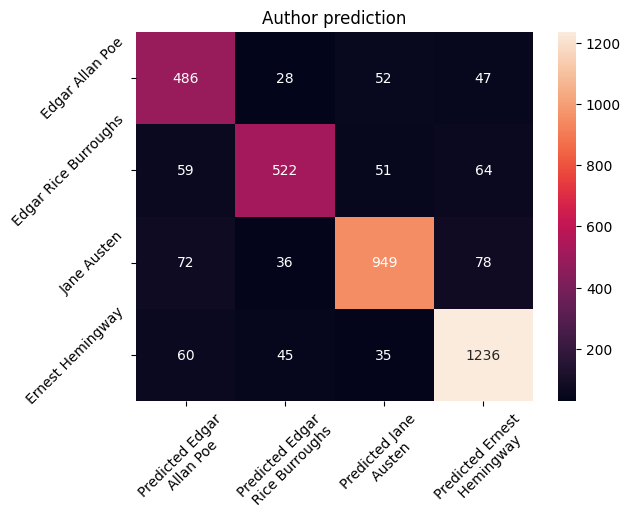

In [25]:
conf=confusion_matrix(Y_test, preds_classes)
sns_plot = sns.heatmap(conf, annot=True, fmt='d')
sns_plot.set_yticklabels(['Edgar Allan Poe', 'Edgar Rice Burroughs', 'Jane Austen', 'Ernest Hemingway'], rotation = 45)
sns_plot.set_xticklabels(['Predicted Edgar\n Allan Poe', 'Predicted Edgar\n Rice Burroughs', 'Predicted Jane\n Austen', 'Predicted Ernest\n Hemingway'], rotation = 45)
sns_plot.set_title('Author prediction');